In [1]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Load the Mnist Dataset

In [3]:
DataPath = r"D:\PatternRecognition_Data"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [4]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

# Autoencoder Network Implementation

In [5]:
class Autoencoder(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(Autoencoder, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
                                           

  def forward(self, x):
    z = self.encoder(x)
    z = self.encoder_end(z.reshape([z.shape[0],-1]))
    y = self.decoder_start(z)
    y = self.decoder(y.reshape([y.shape[0],32,7,7]))
    return y

In [6]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    criterion = nn.MSELoss()
    model.train()
    losses = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses

In [7]:
autoenc_model = Autoencoder(latent_width=100)
summary(autoenc_model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                  [-1, 100]         156,900
            Linear-8                 [-1, 1568]         158,368
   ConvTranspose2d-9           [-1, 16, 14, 14]           2,064
        LeakyReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
  ConvTranspose2d-12            [-1, 1, 28, 28]              65
        LeakyReLU-13            [-1, 1, 28, 28]               0
      BatchNorm2d-14            [-1, 1,

### Train with latent space size 100:

In [8]:
autoenc_model_100 = Autoencoder(latent_width=100)
autoenc_model_100 = autoenc_model_100.cuda()
autoenc_optim_100 = optim.Adam(autoenc_model_100.parameters(), lr=1e-5)
autoenc_losses_100 = train(autoenc_model_100, autoenc_optim_100, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.145796

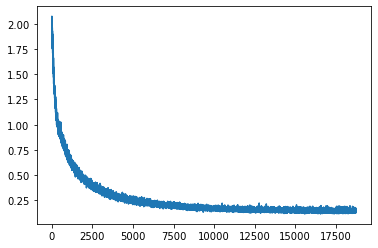

In [9]:
plt.plot(autoenc_losses_100)

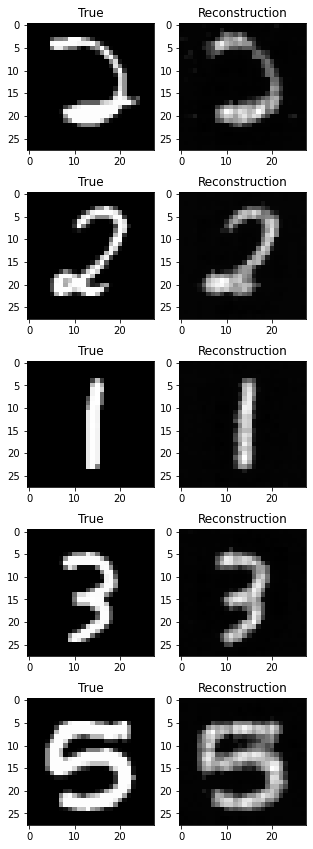

In [10]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_100(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Train with latent space size 10:

In [11]:
autoenc_model_10 = Autoencoder(latent_width=10)

autoenc_model_10 = autoenc_model_10.cuda()

autoenc_optim_10 = optim.Adam(autoenc_model_10.parameters(), lr=1e-5)

autoenc_losses_10 = train(autoenc_model_10, autoenc_optim_10, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.397266

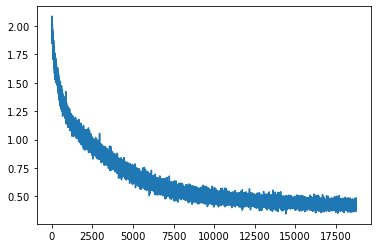

In [12]:
plt.plot(autoenc_losses_10)

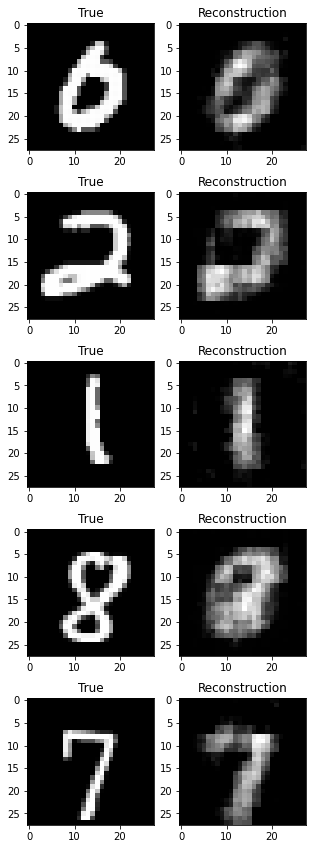

In [13]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_10(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Result:
The smaller latent space compression results in way worse reconstructions!

# Variational Autoencoder Network Implementation